<a href="https://colab.research.google.com/github/trantrongthinh/BTL_DeepLearning/blob/main/BTL_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install librosa tensorflow scikit-learn matplotlib tqdm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical



In [5]:
# Hàm trích xuất Mel Spectrogram
SR = 22050
DURATION = 3.0
N_MELS = 128
MAX_LEN = int(SR * DURATION)

def extract_mel(file_path):
    y, sr = librosa.load(file_path, sr=SR)

    if len(y) < MAX_LEN:
        y = np.pad(y, (0, MAX_LEN - len(y)))
    else:
        y = y[:MAX_LEN]

    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=N_MELS, n_fft=2048, hop_length=512
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)

    mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())
    return mel_db


In [6]:
DATASET_PATH = "/content/drive/MyDrive/IRMAS-TrainingData"

X = []
y = []

for label in sorted(os.listdir(DATASET_PATH)):
    folder = os.path.join(DATASET_PATH, label)
    if not os.path.isdir(folder):
        continue

    for file in tqdm(os.listdir(folder), desc=f"Loading {label}"):
        if file.endswith(".wav"):
            path = os.path.join(folder, file)
            mel = extract_mel(path)
            X.append(mel)
            y.append(label)

X = np.array(X)
X = X[..., np.newaxis]   # (N, 128, T, 1) ← CHỈ 1 LẦN


Loading .ipynb_checkpoints: 0it [00:00, ?it/s]
Loading voi: 100%|██████████| 778/778 [01:14<00:00, 10.42it/s]


In [7]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_mel_samples(X, y, encoder, n_samples=5):
    plt.figure(figsize=(15, 3))

    for i in range(n_samples):
        mel = X[i].squeeze()   # (128, 128)
        label_id = y[i]
        label_name = encoder.inverse_transform([label_id])[0]

        plt.subplot(1, n_samples, i+1)
        librosa.display.specshow(
            mel,
            x_axis='time',
            y_axis='mel',
            sr=22050
        )
        plt.title(label_name)
        plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()


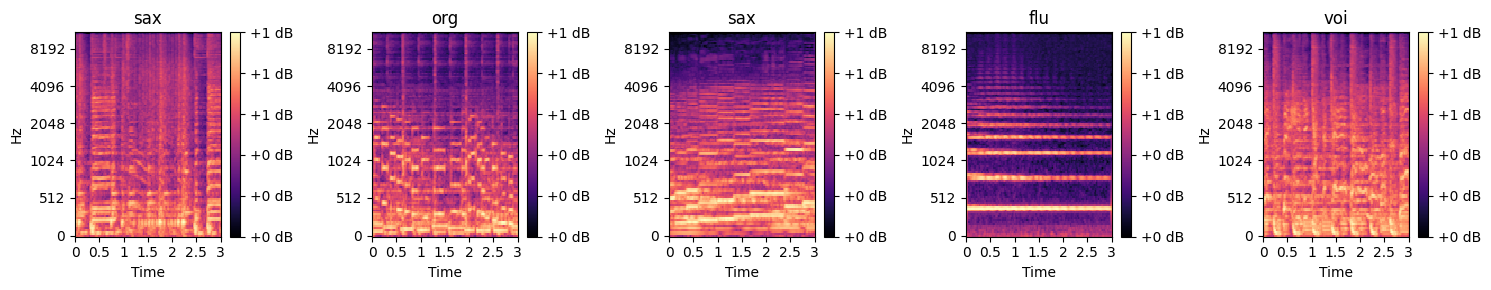

In [11]:
plot_mel_samples(X_train, y_train, encoder, n_samples=5)


In [10]:
# Encode Label
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)


In [12]:
# Khởi tạo CNN
model = models.Sequential([
    layers.Input(shape=X_train.shape[1:]),

    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(encoder.classes_), activation='softmax')
])


In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [14]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=7, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3
    )
]


In [15]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.2321 - loss: 2.2172 - val_accuracy: 0.0671 - val_loss: 2.7043 - learning_rate: 0.0010
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3287 - loss: 1.9276 - val_accuracy: 0.1295 - val_loss: 3.3715 - learning_rate: 0.0010
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.3838 - loss: 1.7927 - val_accuracy: 0.1072 - val_loss: 3.8557 - learning_rate: 0.0010
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4451 - loss: 1.6241 - val_accuracy: 0.2377 - val_loss: 3.2166 - learning_rate: 0.0010
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5159 - loss: 1.4203 - val_accuracy: 0.1966 - val_loss: 3.0211 - learning_rate: 5.0000e-04
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5469 - loss: 1.3517 - val_accuracy: 0.1566 - val_loss: 3.9985 - learning_rate: 5.0000e-04
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5666 -

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 130, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 130, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 65, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 65, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 387,363 (1.48 MB)

 Trainable params: 128,971 (503.79 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 257,944 (1007.60 KB)

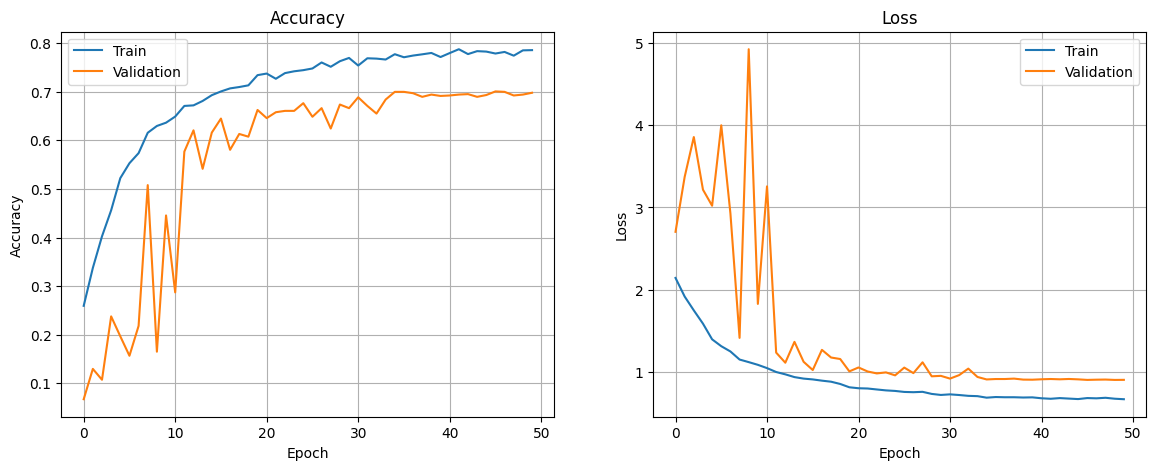

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

# Accuracy
ax[0].plot(history.history['accuracy'], label='Train')
ax[0].plot(history.history['val_accuracy'], label='Validation')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# Loss
ax[1].plot(history.history['loss'], label='Train')
ax[1].plot(history.history['val_loss'], label='Validation')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.show()


In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7113 - loss: 0.8754
Test accuracy: 0.7093889713287354


In [28]:
model.save("/content/drive/MyDrive/irmas_vgg_model.keras")
